<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/workbook_12_principal_component_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCA by hands

Following demo shows how PCA can be performed by means of rotation.
* Datapoints are generated by $2$ Gaussians -- their parameters are changed by means of muA, muB, sigA, sigB sliders.
* After generation, plane with datapoints is rotated by angle alpha -- use corresponding slider to change.
* Datapoints are projected to new $X$ and $Y$ and two histograms are built.
* Red vectors show principal directions.

Use the demo to answer the questions
* How should you rotate the plane to essentially perform PCA?
* How do histograms look like after this rotation?
* What can you say about correlation coefficient when the plane is rotated according to PCA?

In [1]:
#@title Visualization

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import matplotlib.gridspec as gridspec
import ipywidgets as widgets

def rot_matrix(alpha):
  return np.array([[np.cos(alpha), -np.sin(alpha)], 
                   [np.sin(alpha),  np.cos(alpha)]])


@widgets.interact(muA=(-5.0, 5.0), muB=(-5.0,5.0), sigA=(0.1,5.0), sigB=(0.1,5.0), sample_size=(1,500), alpha=(0.0,180.0))
def plot_corr(muA, muB, sigA, sigB, sample_size, alpha):
  np.random.seed(1)
  plt.close('all')
  fig = plt.figure(figsize=(20,8))
  gridspec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=[1, 2, 3], height_ratios=[1, 1, 1])

  subplotspec_histoY = gridspec.new_subplotspec((0, 0), rowspan=2)
  subplotspec_histoX = gridspec.new_subplotspec((2, 1))
  subplotspec_mainPlt = gridspec.new_subplotspec((0, 1), rowspan=2)
  subplotspec_corrPlt = gridspec.new_subplotspec((0, 2))
  subplotspec_koefPlt = gridspec.new_subplotspec((1, 2))
  subplotspec_histos = gridspec.new_subplotspec((2, 2))

  ax_mainPlt = plt.subplot(subplotspec_mainPlt)
  ax_histoY = plt.subplot(subplotspec_histoY, sharey=ax_mainPlt)
  ax_histoX = plt.subplot(subplotspec_histoX, sharex=ax_mainPlt)
  ax_corrPlt = plt.subplot(subplotspec_corrPlt)
  ax_koefPlt = plt.subplot(subplotspec_koefPlt)
  ax_histos = plt.subplot(subplotspec_histos)

  ax_histoX.title.set_text('Histogram of $A \cos(alpha) - B \sin(alpha)$')
  ax_histoY.title.set_text('Histogram of $A \cos(alpha) + B \sin(alpha)$')
  ax_corrPlt.title.set_text('Correlation coefficient')
  ax_koefPlt.title.set_text('Percentage of A in X and Y')
  ax_histos.title.set_text('Histograms overlapping')

  rndA = scipy.stats.norm.rvs(0.0, sigA, size=sample_size)
  rndB = scipy.stats.norm.rvs(0.0, sigB, size=sample_size)

  R = rot_matrix(alpha / 180.0 * np.pi)
  rndXY = (R.dot(np.vstack((rndA, rndB))).T + np.array([muA, muB])).T
  arrDX = R.dot(np.array([sigA, 0]))
  arrDY = R.dot(np.array([0, sigB]))
  ax_mainPlt.scatter(rndXY[0], rndXY[1])
  ax_mainPlt.arrow(muA - arrDX[0], muB - arrDX[1], 2.0 * arrDX[0], 2.0 * arrDX[1], color='r', width=.2)
  ax_mainPlt.arrow(muA - arrDY[0], muB - arrDY[1], 2.0 * arrDY[0], 2.0 * arrDY[1], color='r', width=.2)
  min_val = np.min(np.ravel(rndXY))
  max_val = np.max(np.ravel(rndXY))
  ax_mainPlt.set_xlim(min_val, max_val)
  ax_mainPlt.set_ylim(min_val, max_val)

  ax_histoX.hist(rndXY[0], density=True, color='b')
  ax_histoY.hist(rndXY[1], density=True, orientation='horizontal', color='r')
  ax_histoY.invert_xaxis()

  ax_histos.hist(rndXY[0], density=True, color='b', alpha=.5)
  ax_histos.hist(rndXY[1], density=True, color='r', alpha=.5)

  angles = np.linspace(0.0, np.pi, num=200)
  correlations = []
  for a in angles:
    R = rot_matrix(a)
    XY = (R.dot(np.vstack((rndA, rndB))).T + np.array([muA, muB])).T #R.dot(np.vstack((rndA, rndB)))
    correlations.append(np.corrcoef(XY[0], XY[1])[0,1])
  ax_corrPlt.plot(angles / np.pi * 180.0, correlations)
  idx = np.searchsorted(angles, alpha / 180.0 * np.pi)
  if idx >= angles.shape[0]:
    idx = angles.shape[0] - 1
  ax_corrPlt.plot(alpha, correlations[idx], 'ro') 

  ax_koefPlt.plot(angles / np.pi * 180.0, np.sin(angles))
  ax_koefPlt.plot(angles / np.pi * 180.0, np.cos(angles))
  a_ = angles[idx]
  ax_koefPlt.plot(alpha, np.sin(a_), 'ro') 
  ax_koefPlt.plot(alpha, np.cos(a_), 'ro') 

  plt.tight_layout()

interactive(children=(FloatSlider(value=0.0, description='muA', max=5.0, min=-5.0), FloatSlider(value=0.0, des…

#PCA in 2D

Use the following demo to get intuition on PCA in 2D.

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

def perform_pca(X):
  pca.fit(X)
  return pca

def get_mean():
  return pca.mean_

def get_coordinate_vectors():
  return pca.components_

def get_variances():
  return pca.explained_variance_

In [7]:
#@title PCA on 2D points
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

def draw_vector(v0, v, ax):
  v1 = v0 + v
  for idx in [0, 1]:
    if v1[idx] < -1:
      v1 = v0 - (1 + v0[idx])/v[idx] * v
    if v1[idx] > 1:
      v1 = v0 + (1 - v0[idx])/v[idx] * v
  
  arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0, color='red')
  ax.annotate('', v1, v0, arrowprops=arrowprops)

def plot_pca(X):
  sns.set()
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c='b')
  for length, vector in zip(get_variances(), get_coordinate_vectors()):
    v = vector * 3 * np.sqrt(length)
    draw_vector(get_mean(), v, ax)

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0

  model = perform_pca(X)
  fig = plot_pca(X)

  image_base64 = figure_to_base64(fig)
  return IPython.display.JSON({'image': image_base64})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(50, 50, 50, 0.3)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });
        
        
        
      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }
  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:275px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add data point
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move data point
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete data point
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Do PCA
    </button>
  </div>
  <script> init();</script>
'''



def generate_html():
  s = main_str
  return s
  
display(IPython.display.HTML(generate_html()))
    
    
output.register_callback('notebook.InvSVM', invoke)

#Custom symbols and PCA

Now apply PCA to your own generated dataset.

* As a first step you should generate the dataset. You can create any symbols you like. I've created class Canvas to help you
   - Canvas coordinates are from (0,0) to (100, 100)
   - Use `stroke` function to draw a line compraising segments
   - You can call `stroke` as many times as you need
   - Use `clear` function to clean the canvas 
   - Use `draw` function to see what you've painted
   - Use `get_array_for_dataset` to det symbol in a suitable form for training (Symbol is cut out from canvas, scaled, and transformed into 1D array)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Canvas:
  def __init__(self):
    self.clear()

  def clear(self):
    self.image = np.zeros((100, 100), np.uint8)

  def stroke(self, key_points_arr):
    x0, y0 = key_points_arr[0]
    for x,y in key_points_arr[1:]:
      cv2.line(self.image, (x0, y0), (x, y), (255), 3) # 3 = line_thickness
      x0, y0 = x, y

  def _get_square_frame(self):
    pos = np.nonzero(self.image)
    x_c, y_c = (pos[1].min() + pos[1].max())/2, (pos[0].min() + pos[0].max())/2
    d = np.max([(pos[1].max() - pos[1].min())/2, (pos[0].max() - pos[0].min())/2])
    return x_c, y_c, d

  def rotate(self, angle_degrees):
    x_c, y_c, _ = self._get_square_frame()
    rot_mat = cv2.getRotationMatrix2D((x_c, y_c), angle_degrees, 1.0)
    self.image = cv2.warpAffine(self.image, rot_mat, self.image.shape[1::-1], flags=cv2.INTER_LINEAR)

  def blur(self, strength=2):
    self.image = cv2.GaussianBlur(self.image, (2*strength+1, 2*strength+1), 0)

  def get_full_image(self):
    return self.image

  def get_scaled_image(self):
    x_c, y_c, d = self._get_square_frame()
    crop_img = self.image[int(y_c - d):int(y_c + d), int(x_c - d):int(x_c + d)]
    scaled_img = cv2.resize(crop_img, (28, 28))
    return scaled_img / 255.0

  def get_array_for_dataset(self):
    return self.get_scaled_image().ravel()

  def draw(self):
    plt.subplot(121)
    plt.imshow(self.image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Full image")
    plt.subplot(122)
    plt.imshow(self.get_scaled_image())
    plt.xticks([])
    plt.yticks([])
    plt.title("Scaled for dataset")
    plt.show()


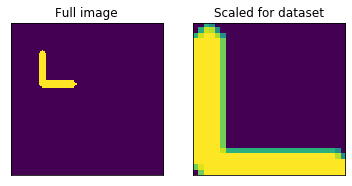

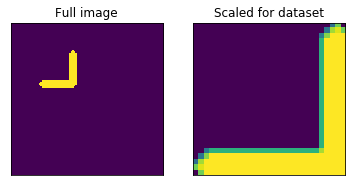

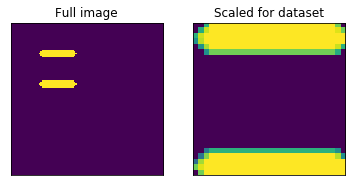

In [ ]:
## Example of drawing symbols
c = Canvas()
# L-symbol
c.clear()
c.stroke([[20, 20], [20, 40], [40, 40]])
c.draw()
# anti-L symbol
c.clear()
c.stroke([[20, 40], [40, 40], [40, 20]])
c.draw()
# = symbol
c.clear()
c.stroke([[20, 40], [40, 40]])
c.stroke([[20, 20], [40, 20]])
c.draw()

In [ ]:
# CREATION OF THE DATASET
X = []
y = []
c = Canvas()

for a in [-10, -5, 0, 5, 10]:
  c.clear()
  c.stroke([[20, 20], [20, 40], [40, 40]])
  c.rotate(a)
  X.append(c.get_array_for_dataset())
  y.append(0)


for a in [-10, -5, 0, 5, 10]:
  c.clear()
  c.stroke([[20, 40], [40, 40], [40, 20]])
  c.rotate(a)
  X.append(c.get_array_for_dataset())
  y.append(1)

Complete the following code
* Perform PCA on your custom symbols and plot the cumulative explained variance ratio as a function of the number of components.
* Think what number of components you would choose for further recognition.

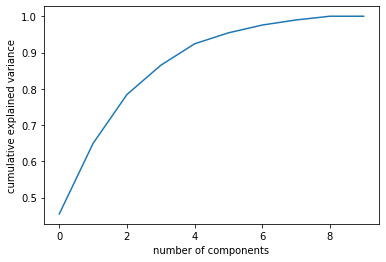

In [ ]:
from sklearn.decomposition import PCA

# Enter your code here
# X contains features, y -- classes

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Complete the following code
* As a step aside consider PCA with $3$ components.
* Transform your dataset accordingly and put the result into `projected` variable.
* The rest of the code contains visualization, use it to check whether the components are separable.
* Think which method looks perspectively to separate the data as good as possible (Bayes, Linear SVM, Kernelized SVM, Decision Tree, Random Forest, etc.)

In [ ]:
from sklearn.decomposition import PCA

# Enter your code here
# X contains features, y -- classes
projected = 



import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

cmap = {0: 'rgba(0,0,255,255)', 1: 'rgba(0,255,0,255)', 2: 'rgba(255,0,0,255)',
        3: 'rgba(0,0,128,255)', 4: 'rgba(0,128,0,255)', 5: 'rgba(128,0,255)',
        6: 'rgba(0,0,64,255)', 7: 'rgba(0,64,0,255)', 8: 'rgba(64,0,0,255)',
        9: 'rgba(0,0,0,255)'}
colors = [cmap[d] for d in y]

fig = make_subplots(rows=1, cols=1, specs=[[{"type": "scene"}]])

fig.add_trace(go.Scatter3d(x=projected[:, 0], y=projected[:, 1], z=projected[:, 2], mode='markers', 
                           marker=dict(size=4, color=colors)),
              row=1, col=1)

fig.update_layout(width=600, height=600, autosize=False, 
                  title_text="3-component PCA for your dataset",
                  scene={"xaxis": {"title": "component 1"},
                         "yaxis": {"title": "component 2"},
                         "zaxis": {"title": "component 3"}},
                  showlegend=False)
      
fig.show()

Complete the following code

* Create a pipeline with PCA and the method you chose.
* Train the classifier, check wether it works well with hand-drawn symbols.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Enter training code here

names = {0: "L", 1:"anti-L"}

def process_symbol(num_img):
    # Enter classification code here
  num_pred = 
  return names[num_pred]

In [ ]:
#@title #Visualization code
import IPython
from google.colab import output
import numpy as np
import json

def do_recognition(array_8x8):
  arr = np.transpose(np.array(array_8x8))
  return IPython.display.JSON({'msg': process_symbol(arr)})

main_str = '''
<body>
  	<div id="paint">
  		<canvas id="myCanvas" width="600" height="600" 
              onmousedown="start_paint(event)"
              onmousemove="do_paint(event)"
              onmouseup="stop_paint(event)"
              style="border:3px solid #000000;">
      </canvas>
	  </div>
    <div style="position:absolute; top:0px; left:625px;">
        <h2> Cropped image </h2>
        <img id="partial_image" style="width:80px; height:80px; border:3px solid #000000;">
        <h2> Scaled </h2>
        <canvas id="bin_canvas" width="80" height="80" 
              style="border:3px solid #000000;">
        </canvas>
        <h2> Recognize symbol </h2>
        <button type="button" onclick="process_data();">
        Do recognition
        </button>
        <h2> Clean canvas </h2>
        <button type="button" onclick="clear_canvas();">
        Clean
        </button>
        <h2> Recognition result </h2>
        <div id="rec_res" style="font-size:40px;"></div>
    </div>
<script>

var canvas = document.getElementById('myCanvas');
var ctx = canvas.getContext('2d');
var canvas_2 = document.getElementById("bin_canvas");
var ctx_2 = canvas_2.getContext("2d");
var mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
var full_image = ctx.getImageData(0, 0, 600, 600);
var partial_image = document.getElementById('partial_image');
var binarized = null;

var N_scaled = 28;

ctx.lineJoin = 'round';
ctx.lineCap = 'round';

 
function start_paint(e)
{
  ctx.putImageData(full_image, 0, 0);
  mouse.state = 1;
  ctx.beginPath();
  ctx.moveTo(mouse.x, mouse.y);
}

var line_width = 28;

function do_paint(e)
{
  mouse.x = e.pageX - 10;
  mouse.y = e.pageY - 10;
  if (!mouse.state)
    return;
  ctx.lineTo(mouse.x, mouse.y);
  ctx.lineWidth = line_width;
  ctx.strokeStyle = '#000000';
  ctx.stroke();
  full_image = ctx.getImageData(0, 0, 600, 600);
  if (mouse.min_x > mouse.x)
    mouse.min_x = mouse.x;
  if (mouse.min_y > mouse.y)
    mouse.min_y = mouse.y;
  if (mouse.max_x < mouse.x)
    mouse.max_x = mouse.x;
  if (mouse.max_y < mouse.y)
    mouse.max_y = mouse.y;
}

function stop_paint(e)
{
  mouse.state = 0;
  full_image = ctx.getImageData(0, 0, 600, 600);

  c_x = (mouse.max_x + mouse.min_x) / 2;
  c_y = (mouse.max_y + mouse.min_y) / 2;
  a = Math.max(mouse.max_x - mouse.min_x, mouse.max_y - mouse.min_y);
  a += line_width;
  var part = ctx.getImageData(c_x - a/2, c_y - a/2, a, a);
  partial_image.src = getImageURL(part);

  binarized = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))
  var counts = Array(N_scaled).fill(0).map(x => Array(N_scaled).fill(0))

  for (var idx_y = 0; idx_y < part.height; idx_y += 1)
    for (var idx_x = 0; idx_x < part.width; idx_x += 1)
    {
      counts[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
      if (part.data[idx_y * part.width * 4 + idx_x * 4 + 3] > 1)
      	binarized[Math.floor(N_scaled * idx_x / part.width)][Math.floor(N_scaled * idx_y / part.height)] += 1;
    }
      	
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
      binarized[i][j] = binarized[i][j] / counts[i][j];

  ctx_2.fillStyle = "rgba(255, 255, 255, 255)";
  ctx_2.fillRect(0, 0, canvas_2.width, canvas_2.height);
  for (var i = 0; i < N_scaled; i++)
    for (var j = 0; j < N_scaled; j++)
    {
      var c = Math.floor(255 - 255*binarized[i][j]);
      var x = Math.floor(canvas_2.width / N_scaled * i);
      var y = Math.floor(canvas_2.height / N_scaled * j);
      var dx = Math.floor(canvas_2.width / N_scaled + 1);
      var dy = Math.floor(canvas_2.height / N_scaled + 1);
      ctx_2.fillStyle = "rgba(" + [c, c, c, 255].join(",") + ")";
      ctx_2.fillRect(x, y, dx, dy);
    }
  
  ctx.lineWidth = 2;
  ctx.strokeStyle = '#FF0000';
  ctx.strokeRect(c_x - a/2, c_y - a/2, a, a);
}

function getImageURL(imgData)
{
   var canvas = document.createElement('canvas');
   var ctx = canvas.getContext('2d');
   canvas.width = imgData.width;
   canvas.height = imgData.height;
   ctx.putImageData(imgData, 0, 0);
   return canvas.toDataURL(); //image URL
}

async function process_data()
{
  const result = await google.colab.kernel.invokeFunction('notebook.DoRec', [binarized], {});
  params = result.data['application/json'];
  document.getElementById('rec_res').innerHTML = params.msg;
}

function clear_canvas()
{
  mouse = {x: 0, y: 0, state: 0, min_x: 600, max_x: 0, min_y: 600, max_y: 0};
  binarized = null;
  ctx.clearRect(0, 0, canvas.width, canvas.height); 
  full_image = ctx.getImageData(0, 0, 600, 600);  
  ctx_2.clearRect(0, 0, 80, 80);   
  var part = ctx.getImageData(0, 0, 80, 80);
  partial_image.src = getImageURL(part);
  document.getElementById('rec_res').innerHTML = "";
}

    </script>
  </body>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.DoRec', do_recognition)

* Try different settings: turn PCA on and off and check whether everything works better.
* Enrich your dataset with rotated and blurred symbols. Canvas already contains
    - `rotate` to rotate symbol
    - `blur` to blur symbol
    - feel free to use draw whenever you are not sure, what you've drawed
* Repeat plotting cumulative variance and PCA with $3$ components.
* Retrain your classifier and check whether it gets better.
* Enrich your dataset with somehow warped symbols (think about some randomization when calling `stroke`) and repeat the workflow.